In [194]:
import itertools
import os
import pandas
from matplotlib import pyplot
from numpy import linspace
from pandas import Series, DataFrame
from pathlib import Path
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from typing import Tuple, List

from visualisation import savefig

for folder in itertools.chain([Path.cwd()], Path.cwd().parents):
    if (folder / 'Pipfile').exists():
        os.chdir(folder)
        break

from utils import balanced_range


from custom_types import ModelCVResult, ModelResult
from evaluation_functions import get_1_class_y_score, get_train_test_sampling, \
    display_classification_metrics_from_simple_cv_results, evaluate_method_on_sets, DefaultHyperParameters, \
    get_cv_results_from_simple_cv_evaluation, join_repeats_and_folds_cv_results, ObjectiveFunctionResultWithPayload, \
    get_classification_metrics_from_simple_cv_results
from functional import statements, pipe, unzip, t, unpack_args
from notebooks.heart_transplant.dependencies.heart_transplant_pipelines import get_random_forest_pipeline

import itertools
import os
from pathlib import Path
for folder in itertools.chain([Path.cwd()], Path.cwd().parents):
    if (folder / 'Pipfile').exists():
        os.chdir(folder)
        break

from notebooks.heart_transplant.dependencies.heart_transplant_data import get_reduced_binary_dataset_cached
import matplotlib

FIGURES_FOLDER  = './data/heart_transplant/figures'
DEFAULT_FIGURE_SIZE = (6, 6)

%load_ext autoreload
%autoreload 2
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams["figure.facecolor"] = 'white'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

def preprocess(_X: DataFrame, _y: Series, _dataset_raw: DataFrame) -> Tuple[DataFrame, Series, DataFrame]:
    _X_sorted = _X\
        .assign(tx_year=_dataset_raw.loc[_X.index]['tx_year'])\
        .sort_values(by='tx_year')

    _X_sorted = _X_sorted\
        .drop(_X_sorted[_X_sorted['tx_year'] > 2015].index)\
        .drop(columns='tx_year')

    _y_sorted = _y.loc[_X_sorted.index]

    return _X_sorted, _y_sorted, _dataset_raw

X_365, y_365, dataset_raw = preprocess(*get_reduced_binary_dataset_cached())


[Memory]0.8s, 0.0min    : Loading get_reduced_binary_dataset...


In [3]:
pipeline = get_random_forest_pipeline(X_365, y_365)

In [7]:
results: ObjectiveFunctionResultWithPayload = evaluate_method_on_sets(
    lambda: get_random_forest_pipeline(X_365, y_365, n_jobs=2),
    X_365,
    y_365,
    DefaultHyperParameters(),
    splits=get_train_test_sampling(X_365, 0.5),
    parallel=True,
    n_jobs=10,
)

.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


In [8]:
cv_results: List[ModelCVResult] = get_cv_results_from_simple_cv_evaluation([results])

In [9]:
results_joined: ModelResult = join_repeats_and_folds_cv_results(cv_results)

In [10]:
tx_date = pandas.to_datetime(dataset_raw['tx_date'])

In [11]:
y_score: Series = get_1_class_y_score(results_joined['y_test_score'])
y_true_for_score = y_365.loc[y_score.index]
distance_data = DataFrame(dict(
    error=(y_true_for_score-y_score)**2,
    tx_year=tx_date.loc[y_score.index],
    tx_date=tx_date.loc[y_score.index],
    y_score=y_score
))

<AxesSubplot:xlabel='tx_date', ylabel='error'>

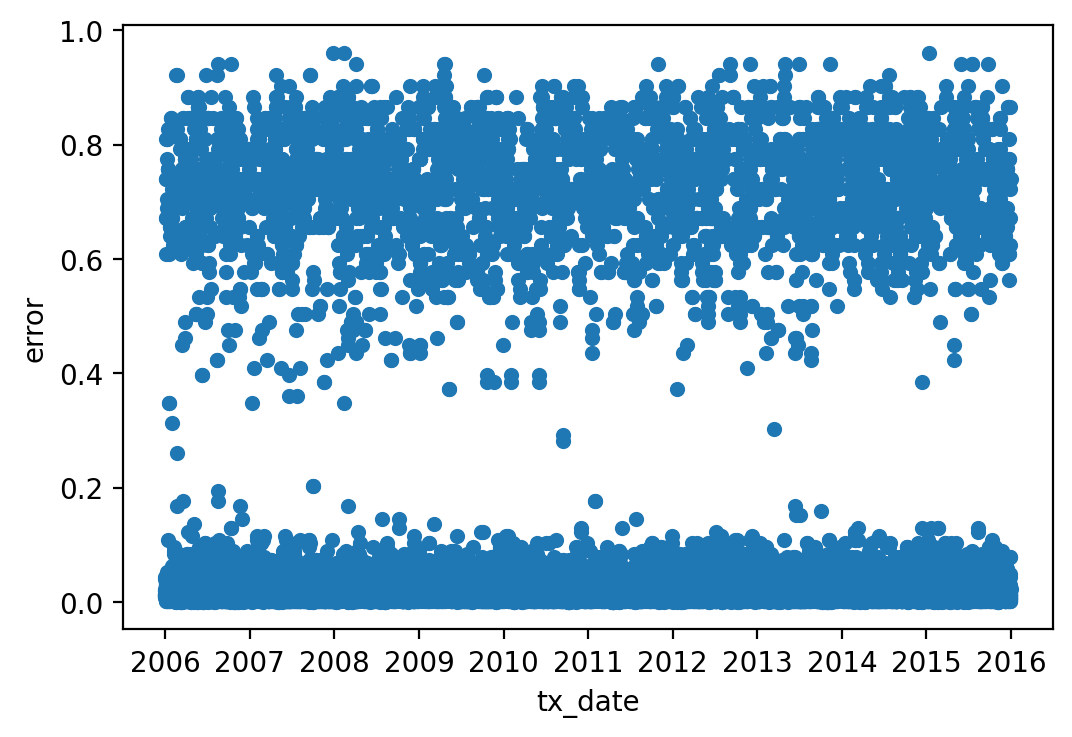

In [12]:
distance_data.plot.scatter(x='tx_date', y='error')

[((2006, 1), (2006, 2), (2006, 3), (2006, 4), (2006, 5), (2006, 6), (2006, 7), (2006, 8), (2006, 9), (2006, 10), (2006, 11), (2006, 12), (2007, 1), (2007, 2), (2007, 3), (2007, 4), (2007, 5), (2007, 6), (2007, 7), (2007, 8), (2007, 9), (2007, 10), (2007, 11), (2007, 12), (2008, 1), (2008, 2), (2008, 3), (2008, 4), (2008, 5), (2008, 6), (2008, 7), (2008, 8), (2008, 9), (2008, 10), (2008, 11), (2008, 12), (2009, 1), (2009, 2), (2009, 3), (2009, 4), (2009, 5), (2009, 6), (2009, 7), (2009, 8), (2009, 9), (2009, 10), (2009, 11), (2009, 12), (2010, 1), (2010, 2), (2010, 3), (2010, 4), (2010, 5), (2010, 6), (2010, 7), (2010, 8), (2010, 9), (2010, 10), (2010, 11), (2010, 12), (2011, 1), (2011, 2), (2011, 3), (2011, 4), (2011, 5), (2011, 6), (2011, 7), (2011, 8), (2011, 9), (2011, 10), (2011, 11), (2011, 12), (2012, 1), (2012, 2), (2012, 3), (2012, 4), (2012, 5), (2012, 6), (2012, 7), (2012, 8), (2012, 9), (2012, 10), (2012, 11), (2012, 12), (2013, 1), (2013, 2), (2013, 3), (2013, 4), (2013, 5)

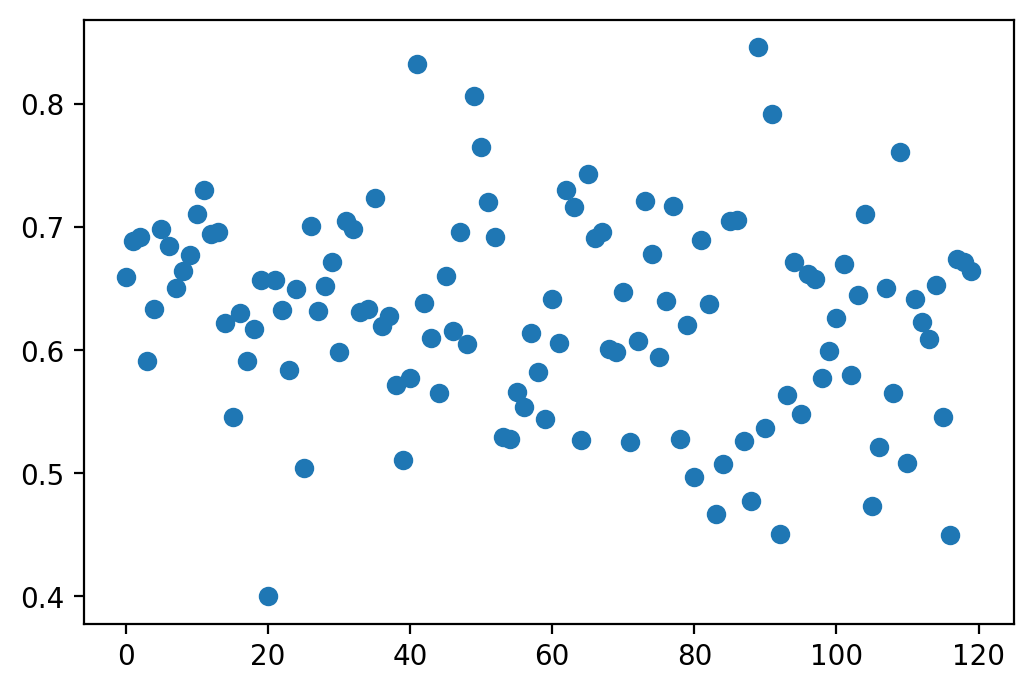

In [13]:

pipe(
    (
        [
            time_period,
            roc_auc_score(
                statements(
                    x := y_365.loc[group['y_score'].index],
                    # print(x.value_counts()),
                    x,
                ),
                group['y_score'],
            ),
        ]
        for time_period, group
        in distance_data.groupby([
            distance_data['tx_date'].dt.year,
            distance_data['tx_date'].dt.month
        ])
    ),

    unzip,
    list,
    t,
    unpack_args(lambda x, y: pyplot.scatter(range(len(x)), y))
)

[(2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015), (0.6749103656776507, 0.6093062540432347, 0.6434825204585554, 0.6142913044253675, 0.6176939916213844, 0.6396524152586015, 0.6192415864535775, 0.6202278169674413, 0.6039862381208535, 0.607785533662515)]


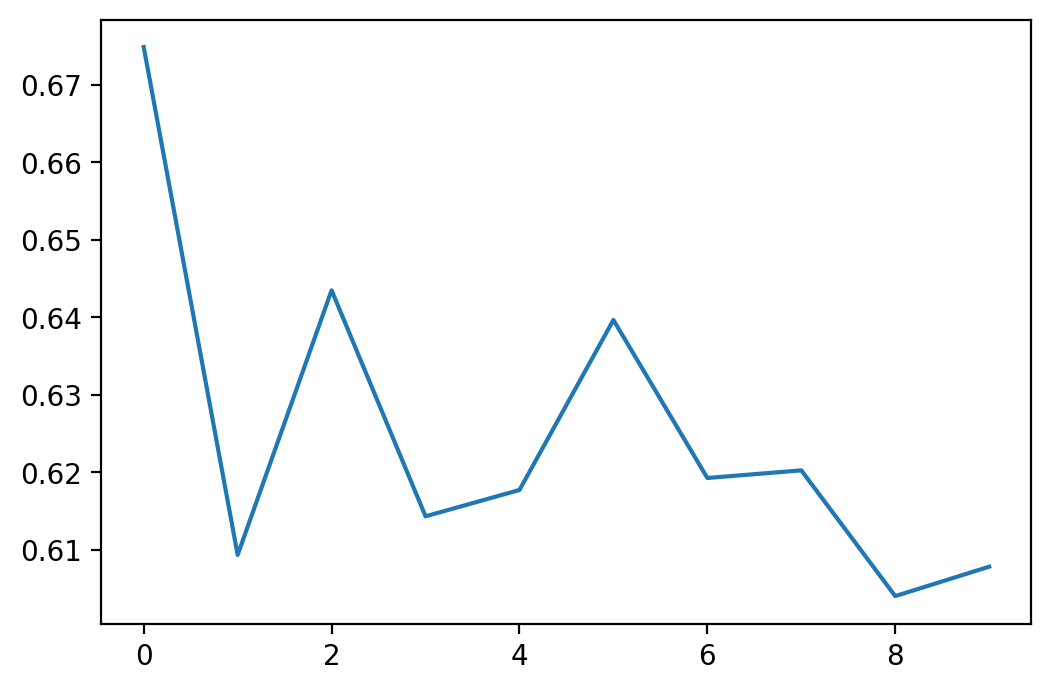

In [14]:

pipe(
    (
        [
            time_period,
            roc_auc_score(
                statements(
                    x := y_365.loc[group['y_score'].index],
                    x,
                ),
                group['y_score'],
            ),
        ]
        for time_period, group
        in distance_data.groupby([
            distance_data['tx_date'].dt.year,
        ])
    ),

    unzip,
    list,
    t,
    unpack_args(lambda x, y: pyplot.plot(range(len(x)), y))
)

In [15]:
sc = cross_val_score(get_random_forest_pipeline(X_365, y_365), X_365, y_365, cv=KFold(n_splits=10).split(X_365))

In [5]:
cv_sampling = get_train_test_sampling(X_365, 0.5)


In [154]:
rocs = []
fractions = []
for proportion in linspace(1, 0, num=30):
    print(proportion)

    X_shuffled = X_365.sample(frac=proportion,  random_state=1235)
    X_ordered = X_365.loc[set(list(X_365.index)) - set(list(X_shuffled.index))]

    X_final = pandas.concat([
        X_shuffled,
        X_ordered,
    ])

    y_final = y_365.loc[X_final.index]

    results: ObjectiveFunctionResultWithPayload = evaluate_method_on_sets(
        lambda: get_random_forest_pipeline(X_final, y_final, n_jobs=2),
        X_final,
        y_final,
        DefaultHyperParameters(),
        splits=get_train_test_sampling(X_final, 0.5),
        parallel=True,
        n_jobs=10,
    )

    metrics = get_classification_metrics_from_simple_cv_results(y_final, results)

    fractions.append(proportion)
    rocs.append(metrics['roc_auc'].mean)

1.0
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.9655172413793104
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.9310344827586207
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.896551724137931
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.8620689655172413
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.8275862068965517
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.7931034482758621
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.7586206896551724
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.7241379310344828
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.6896551724137931
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.6551724137931034
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.6206896551724138
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.5862068965517242
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.5517241379310345
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.5172413793103449
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.48275862068965514
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.4482758620689655
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.4137931034482759
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.3793103448275862
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.3448275862068966
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.31034482758620685
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.27586206896551724
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.24137931034482762
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.2068965517241379
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.1724137931034483
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.13793103448275867
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.10344827586206895
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.06896551724137934
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.034482758620689724
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.0
.


/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sitnarf/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


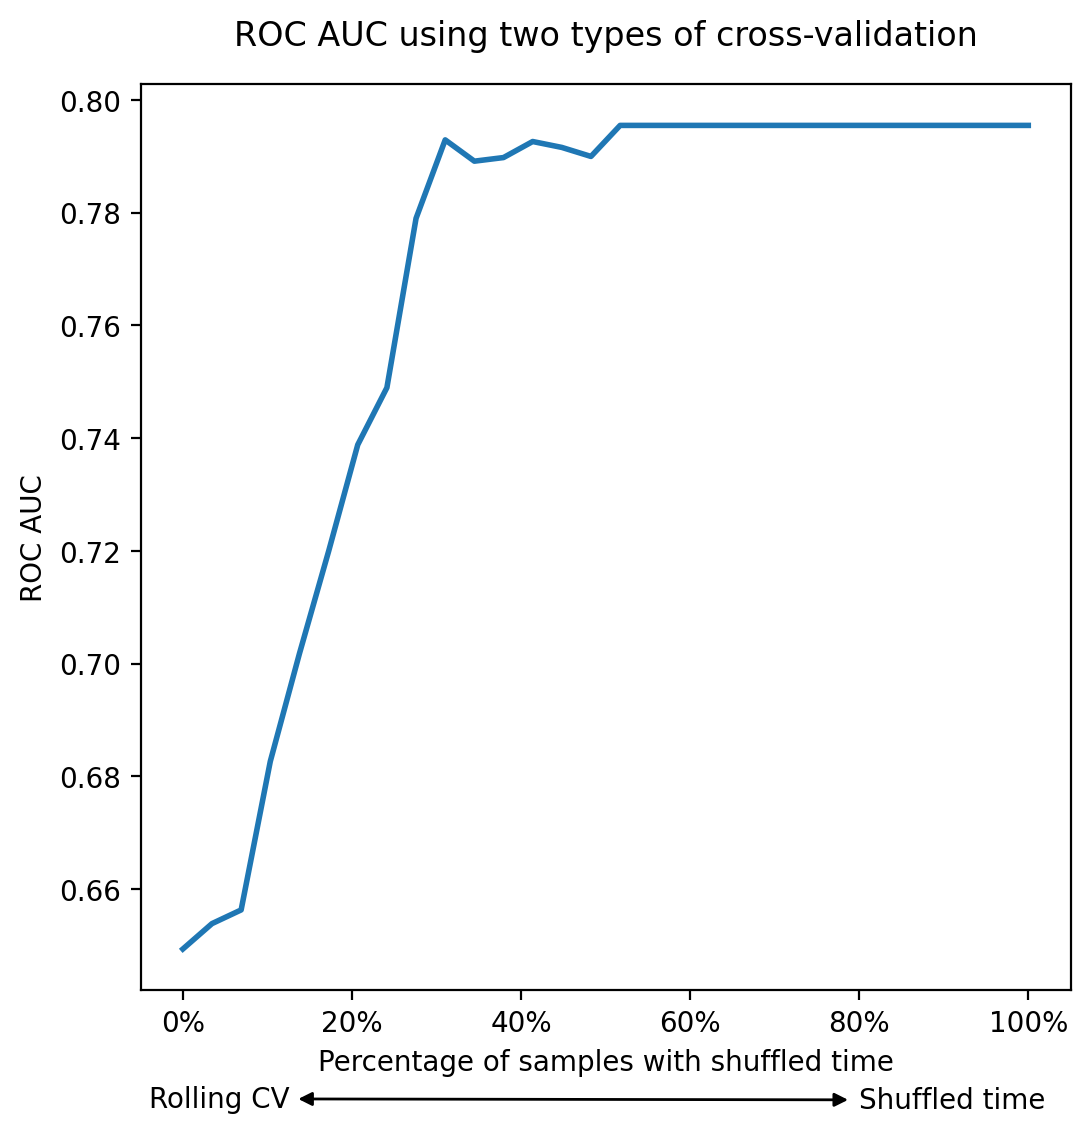

In [205]:
import matplotlib.ticker as mtick
pyplot.figure(figsize=(6,6))
pyplot.plot(fractions, rocs, lw=2)
pyplot.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pyplot.xlabel('Percentage of samples with shuffled time')
pyplot.ylabel('ROC AUC')
xmin, xmax = pyplot.gca().get_xlim()
ymin, ymax = pyplot.gca().get_ylim()

pyplot.title('ROC AUC using two types of cross-validation', pad=14)

pyplot.gca().annotate(
    "Shuffled time",
    xy=(xmin+0.18, -0.12),
    xytext=(xmax-0.25, -0.13),
    arrowprops=dict(arrowstyle="<|-|>", color='black'),
    xycoords=pyplot.gca().get_xaxis_transform()
)

pyplot.gca().text(
    s="Rolling CV",
    x=xmin+0.01,
    y=ymax-0.1815,
)

savefig(FIGURES_FOLDER+'/illustrations/shuffled-performance.svg')